In [1]:
import os
os.chdir("..")

In [2]:
from commons.api.utils import set_to_our_gpus, enable_web_access
set_to_our_gpus()
enable_web_access()

In [3]:
# from juneja.validation_pipeline.preprocess import img_to_tensor
# from juneja.validation_pipeline.metrics import normalize, match_hist, normalize_map, SIM, CC, NSS
# from api.metrics import apply_grey_patch, add_random_noise_to_image
# from juneja.validation_pipeline.inference import generate_saliency

from commons.api.imagenet_tiny import get_imagenet_classes, get_random_images

from commons.api.metric.compare_metrics import normalize, match_hist, normalize_map
from commons.api.metric.compare_metrics import SIM, CC, NSS, AUC_Judd, wasserstein_distance
from commons.api.metric.compare_metrics import calculate_metrics

# from shardul.ScoreCAM.cam import CAM, GradCAM, GradCAMpp, SmoothGradCAMpp, ScoreCAM
# from shardul.ScoreCAM.utils.visualize import visualize, reverse_normalize
# from shardul.ScoreCAM.utils.imagenet_labels import label2idx, idx2label


from shardul.api.viz import visualize_saliency_overlay
from commons.api.imagenet_tiny import get_imagenet_classes, get_random_images


In [4]:
import matplotlib
import matplotlib.gridspec as gridspec


from PIL import Image
from PIL import Image, ImageDraw
from scipy.signal import convolve2d
from numpy import random
import random
import torch
import numpy as np
import matplotlib.pyplot as plt
import skimage.transform
import torch
import torch.nn as nn
import torch.nn.functional as F
from scipy.spatial.distance import cdist
from cv2 import EMD
from captum.attr import LayerAttribution, LayerGradCam
import cv2
# from ScoreCAM import cam

from PIL import Image
from matplotlib.pyplot import imshow
from torchvision import models, transforms
from torchvision.utils import save_image

In [5]:
# use_cuda = True
# device = torch.device("cuda" if use_cuda else "cpu")
# model_gpu = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True).to(device)
# # model_cpu = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
# model_gpu.eval();
# target_layer = model_gpu.layer4[1].conv2
# classes = get_imagenet_classes()
# resnet_transform = transforms.Compose([transforms.Resize((256, 256)),
#                                        transforms.ToTensor(),
#                                        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])

# scorecam_wrapped_model = ScoreCAM(model_gpu, target_layer)
# gradcam_wrapped_model = GradCAM(model_gpu, target_layer)

In [6]:
def gkern(l=5, sig=1.):
    # side length `l`
    # sigma `sig`
    ax = np.linspace(-(l - 1) / 2., (l - 1) / 2., l)
    gauss = np.exp(-0.5 * np.square(ax) / np.square(sig))
    kernel = np.outer(gauss, gauss)
    return kernel / np.sum(kernel)

def generate_focus_point(img, focus_points):
    img = Image.fromarray(img)
    draw = ImageDraw.Draw(img)
    for idx, fp in enumerate(focus_points):
        p, r, fill_value = fp
        left_up_point = (p[0]-r, p[1]-r)
        right_down_point = (p[0]+r, p[1]+r)
        two_point_list = [left_up_point, right_down_point]
        draw.ellipse(two_point_list, fill=fill_value)
    img_np = np.array(img)
    kernel = gkern(30, 7)
    img_np = convolve2d(img_np, kernel, mode="same")
    return img_np

In [7]:
def plot_comparison_focus_points(focus_points, changes, name):
    fig , axes = plt.subplots(ncols=2, nrows=1)
#     fig.set_figheight(12)
    fig.set_figwidth(12)

    sal_1 = generate_focus_point(blank_img, focus_points)
    axes[0].imshow(sal_1)
    axes[0].set_title("Reference")
    for idx, fp in enumerate(focus_points):
        xy, r, fill_value = fp
        x, y = xy
        axes[0].text(x-10, y+4, f'{idx}:{fill_value:.1f}', color="navy", fontsize=15)
        

    changed_focus_ps = []
    for idx, change in enumerate(changes):
        translate, scale, value = change
        fp = []
        pos = [focus_points[idx][0][0] + translate[0],  focus_points[idx][0][1] + translate[1]]
        fp.append(pos)
        fp.append(focus_points[idx][1] * scale)
        fp.append(focus_points[idx][2] * value)
        changed_focus_ps.append(fp)

    sal_2 = generate_focus_point(blank_img, changed_focus_ps)
    axes[1].imshow(sal_2)
    for idx, fp in enumerate(changed_focus_ps):
        xy, r, fill_value = fp
        x, y = xy
        axes[1].text(x-10, y+4, f'{idx}:{fill_value:.1f}', color="navy", fontsize=15)
    axes[1].set_title(f"Comparative. SIM = {SIM(sal_1, sal_2):.4f}");
    for ax in axes:
        ax.axis('off')
    fig.suptitle("SIM", fontsize=16, fontweight="bold", y=0.95, x = 0.51)
    fig.savefig(f"/project/validating_attribution_techniques/shardul/data/Doc/Background/Metrics/SIM/{name}.png")

In [8]:
blank_img = np.zeros((224, 224))
focus_points = [[[140, 140], 20, 1.0], # 0
                [[130, 80], 15, 0.4], # 1
                [[100, 160], 10, 0.8], # 2
                [[160, 100], 16, 0.4], # 3
                [[75, 90], 15, 0.7]]  # 4

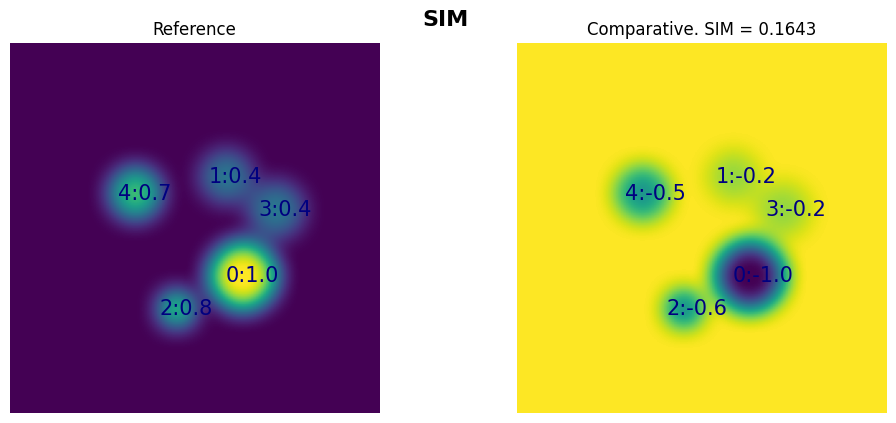

In [9]:
## Location same, radius same, saliency change
plot_comparison_focus_points(focus_points, [[(0, 0), 1, -1], # 0
                                                [(0, 0), 1, -0.4], # 1
                                                [(0, 0), 1, -0.8], # 2
                                                [(0, 0), 1, -0.4], # 3
                                                [(0, 0), 1, -0.7]], 'Saliency_change') # 4

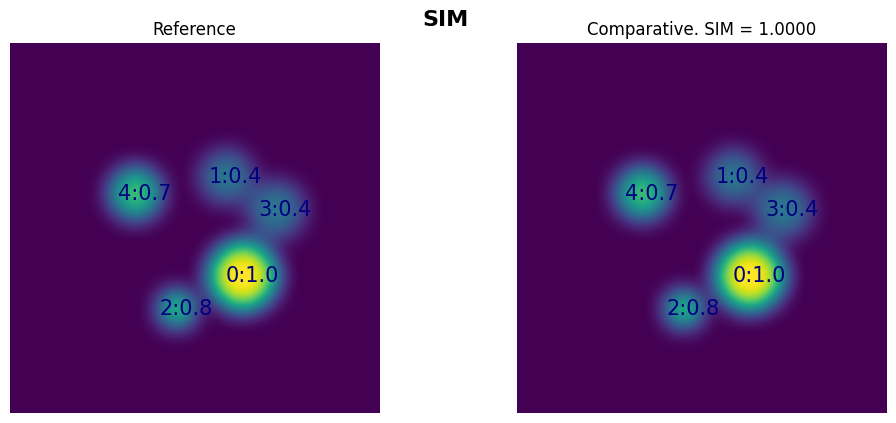

In [10]:
# Positive case where the both the saliencies are same in location and intensity
plot_comparison_focus_points(focus_points, [[(0, 0), 1, 1], # 0
                                                [(0, 0), 1, 1], # 1
                                                [(0, 0), 1, 1], # 2
                                                [(0, 0), 1, 1], # 3
                                                [(0, 0), 1, 1]], 'Saliency_Original') # 4

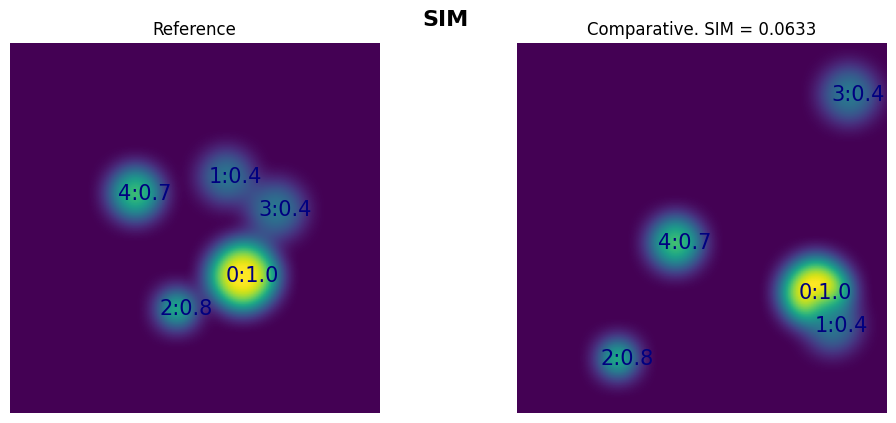

In [11]:
#Location of point is changed but not saliency values
plot_comparison_focus_points(focus_points, [[(40, 10), 1, 1], # 0
                                                [(60, 90), 1, 1], # 1
                                                [(-40, 30), 1, 1], # 2
                                                [(40, -70), 1, 1], # 3
                                                [(20, 30), 1, 1]],'Saliency_change_1') # 4

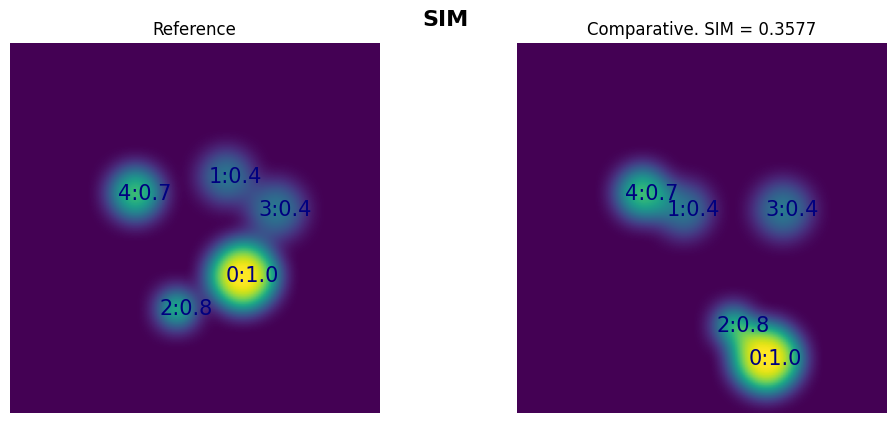

In [12]:
# Location Same
plot_comparison_focus_points(focus_points, [[(10, 50), 1, 1], # 0
                                                [(-30, 20), 1, 1], # 1
                                                [(30, 10), 1, 1], # 2
                                                [(0, 0), 1, 1], # 3
                                                [(0, 0), 1, 1]], 'Saliency_change_2') # 4

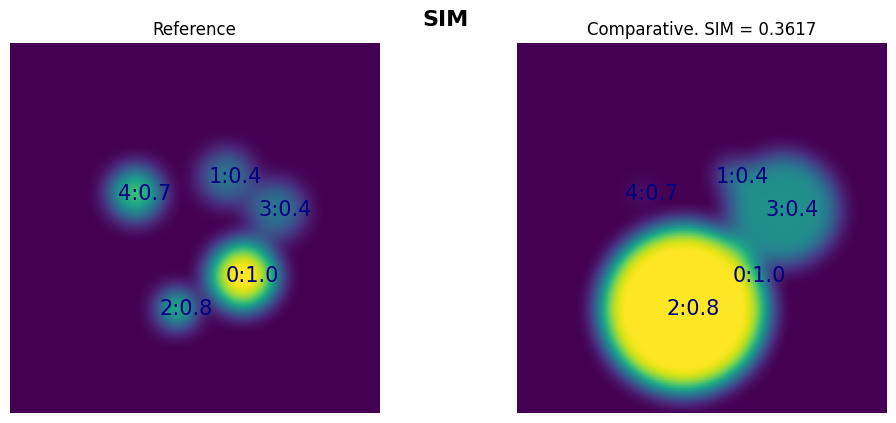

In [13]:
plot_comparison_focus_points(focus_points, [[(0, 0), 0.1, 1], # 0
                                                [(0, 0), 0.5, 1], # 1
                                                [(0, 0), 5, 1], # 2
                                                [(0, 0), 2, 1], # 3
                                                [(0, 0), 0.1, 1]], 'Saliency_change_3') # 4

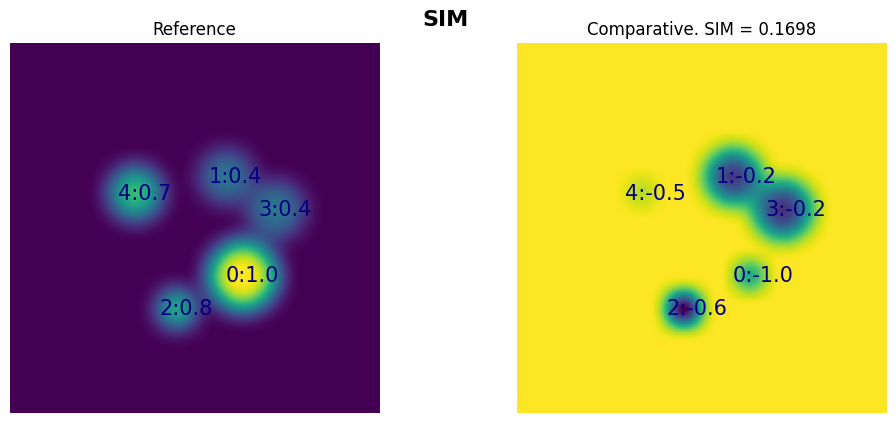

In [14]:
plot_comparison_focus_points(focus_points, [[(0, 0), 0.1, -1], # 0
                                                [(0, 0), 1, -0.4], # 1
                                                [(0, 0), 0.5, -0.8], # 2
                                                [(0, 0), 1, -0.4], # 3
                                                [(0, 0), 0.1, -0.7]], 'Saliency_change_3') # 4

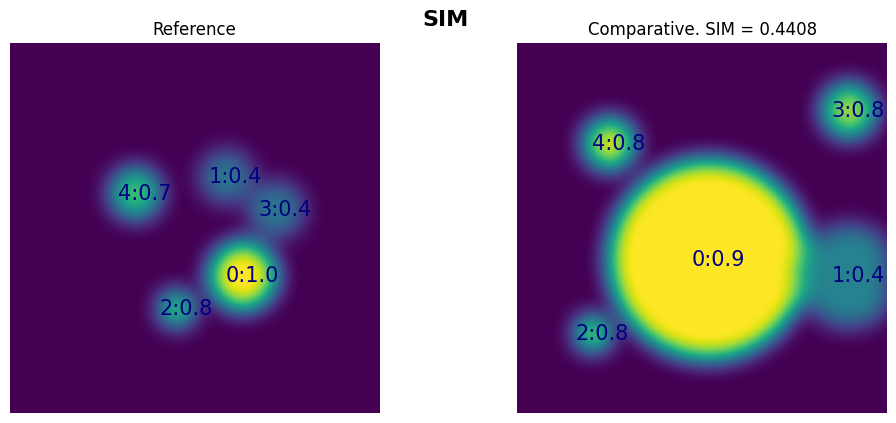

In [21]:
#Location of point is changed
plot_comparison_focus_points(focus_points, [[(-25, -10), 3, 0.9], # 0
                                                [(70, 60), 2, 1], # 1
                                                [(-55, 15), 1, 1], # 2
                                                [(40, -60), 1, 1.9], # 3
                                                [(-20, -30), 1, 1.2]], name = 'Saliency_location_radius_2') # 4